In [1]:
import mido
import os
import numpy as np
from scipy import stats
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow.contrib import rnn
import time

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12, 8)

In [2]:
TICKS_PER_BEAT = 480
TEMPO = int(mido.bpm2tempo(120))

In [3]:
%run get_training_data.py

### Create training data

In [4]:
# Set num training examples here. Note: actual number will be less, since some have errors
training_data, training_data_labels = get_training_vectors_from_file('TRAINING_DATA_6000.txt')

In [5]:
print("Number of training examples:", len(training_data))
training_data_labels[:20]

Number of training examples: 5744


['FridayThe13th_-_MapDark.mid',
 'gymleader2.mid',
 'Zelda_IV_-_Tail_Cave.mid',
 'cv1-4.mid',
 'MM3-Snake_Man.mid',
 'smlboss.mid',
 'molemania_snow.mid',
 'dw4batl.mid',
 'mm1wily2.mid',
 'dd-intermission.mid',
 '1999.mid',
 'FiremanByCryogen.mid',
 'Heavy_Barrel_-_Boss_BGM.mid',
 'Train.mid',
 'Wizards_and_Warriors_II_Ironsword_-_Wind_Elemental.mid',
 'DK-07-Iceberg.mid',
 'supercend.mid',
 'DW4TALN.mid',
 'shatter2_v10.mid',
 'Spark_Man.mid']

### Data Profiling

In [6]:
vocab_size = 722

In [19]:
notes = np.array([])
for data in training_data[:1000]:
    notes = np.append(notes, data)

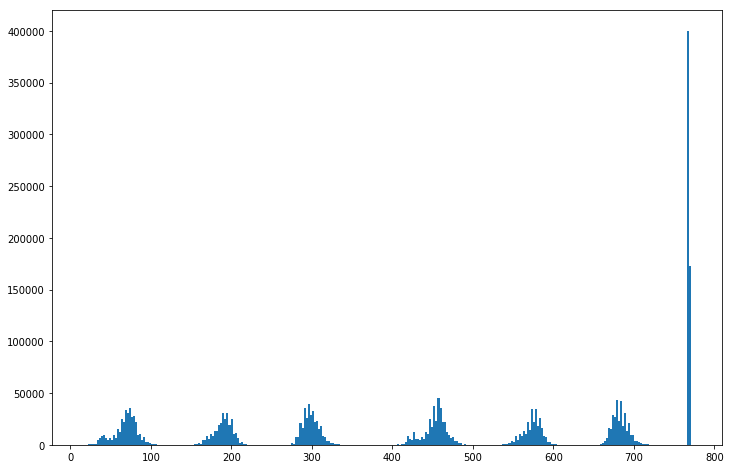

In [20]:
plt.hist(notes, bins=300)
plt.show()

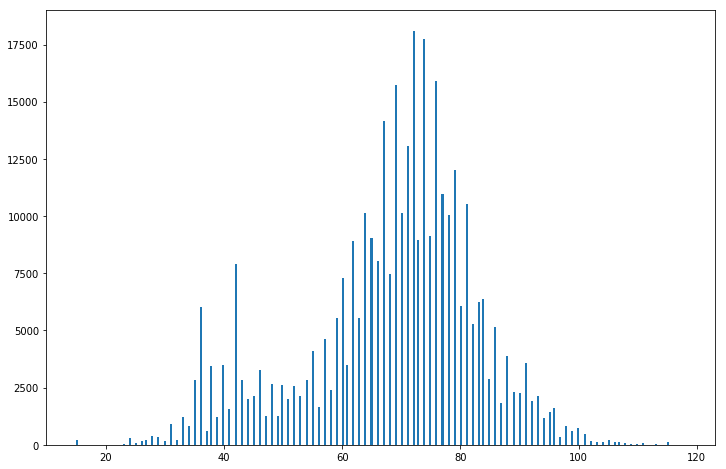

In [25]:
plt.hist([x for x in notes if x<128], bins=300)
plt.show()

In [26]:
count = {}
for note in notes:
    if note not in count:
        count[note] = 0
    count[note] += 1
    
pdf = np.array(list(count.values())) / len(notes)
entropy = -np.sum([p*np.log(p) for p in pdf])
entropy

5.0273174381855492

In [27]:
count = {}
for note in [x for x in notes if x < 128]:
    if note not in count:
        count[note] = 0
    count[note] += 1
    
pdf = np.array(list(count.values())) / len(notes)
entropy = -np.sum([p*np.log(p) for p in pdf])
entropy

0.85106195938435625

### Single song

In [16]:
index = 0
data = training_data[index]
training_data_labels[index]

'FridayThe13th_-_MapDark.mid'

In [17]:
data.shape

(1613,)

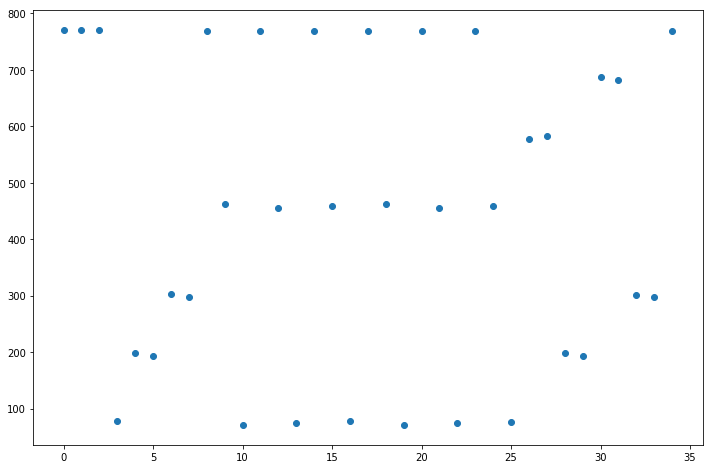

In [18]:
N = 35
plt.scatter(range(N), data[:N])
plt.show()

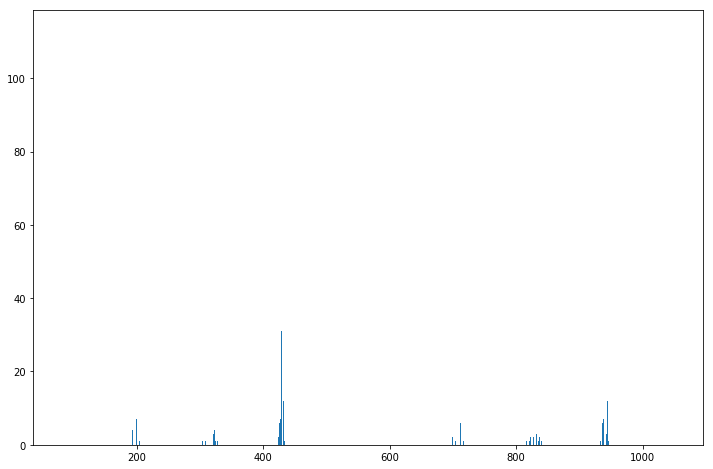

In [85]:
plt.hist(labels, bins=1000)
plt.show()

In [86]:
# Calculate entropy
pdf = np.array([np.sum(labels==i) for i in set(labels)]) / len(labels)

In [87]:
entropy = -np.sum([p*np.log(p) for p in pdf])
entropy

2.9029592019544155

### Recover original file

In [69]:
def get_track_sequences(vector_sequence):
    """Get note sequences for each track from vector sequence output from RNN.

    Args:
       vector_sequence: List of one-hot vectors containing 128 * NUM_TRACKS note_on events, 128 * NUM_TRACKS note_off events,
        and NUM_TIMESHIFTS timeshift events in intervals of 1/96 of a beat each.
       
    Returns:
        List of track vector sequences.
    """
    track_sequences = [[] for _ in range(NUM_TRACKS)]
    start_time = 0
    for vector in vector_sequence:
        index = vector.index(1)
        # vector is a time event.
        if index >= NUM_MIDI_PITCHES * 2 * NUM_TRACKS:
            num_beats = (index - NUM_MIDI_PITCHES * 2 * NUM_TRACKS + 1) / NUM_TIMESHIFTS
            start_time += num_beats
        else:
            # vector is a note_off event.
            if index >= NUM_MIDI_PITCHES * NUM_TRACKS:
                note_type = 'note_off'
                index -= NUM_MIDI_PITCHES * NUM_TRACKS
            # vector is a note_on event.
            else:
                note_type = 'note_on'
            track_num = int(index / NUM_MIDI_PITCHES)
            note = index % NUM_MIDI_PITCHES
            track_sequences[track_num].append({"type": note_type, "note": note, "start_time": start_time})
            time_delay = 0
            
    return track_sequences

In [70]:
def get_midi_from_vector_sequence(track_sequences):
    """Get midi from track sequences.

    Args:
       track_sequences: List of vector sequences for each track.
       
    Returns:
        MidiFile object.
    """
    mid = mido.MidiFile()
    tracks = [mido.MidiTrack() for _ in range(NUM_TRACKS)]
    mid.tracks.extend(tracks)

    for i, ts in enumerate(track_sequences):
        prev_start_time = 0
        for event in ts:
            time = event["start_time"] - prev_start_time
            prev_start_time = event["start_time"]
            # I picked a random number for velocity.
            mid.tracks[i].append(mido.Message(event["type"], note=event["note"], velocity=50,
                                              time=int(time * TICKS_PER_BEAT)))
    
    return mid

In [71]:
track_sequence = get_track_sequences([list(x) for x in data])
track_sequence[1]

[{'note': 60, 'start_time': 0, 'type': 'note_on'},
 {'note': 60, 'start_time': 3.0, 'type': 'note_off'},
 {'note': 67, 'start_time': 3.0, 'type': 'note_on'},
 {'note': 67, 'start_time': 3.5, 'type': 'note_off'},
 {'note': 60, 'start_time': 3.5, 'type': 'note_on'},
 {'note': 60, 'start_time': 6.5, 'type': 'note_off'},
 {'note': 58, 'start_time': 6.5, 'type': 'note_on'},
 {'note': 58, 'start_time': 7.0, 'type': 'note_off'},
 {'note': 55, 'start_time': 7.0, 'type': 'note_on'},
 {'note': 55, 'start_time': 7.5, 'type': 'note_off'},
 {'note': 58, 'start_time': 7.5, 'type': 'note_on'},
 {'note': 58, 'start_time': 8.0, 'type': 'note_off'},
 {'note': 60, 'start_time': 8.0, 'type': 'note_on'},
 {'note': 60, 'start_time': 11.0, 'type': 'note_off'},
 {'note': 62, 'start_time': 11.0, 'type': 'note_on'},
 {'note': 62, 'start_time': 11.5, 'type': 'note_off'},
 {'note': 63, 'start_time': 11.5, 'type': 'note_on'},
 {'note': 63, 'start_time': 12.0, 'type': 'note_off'},
 {'note': 60, 'start_time': 12.0, 

In [72]:
midi = get_midi_from_vector_sequence(track_sequence)
midi

<midi file None type 1, 4 tracks, 868 messages>

In [73]:
midi.save("Batmango-test.mid")